In [1]:
from configparser import ConfigParser
import psycopg2
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import recall_score, precision_score
#Can be very helpful to notice any imbalance in classes
from collections import Counter 

In [2]:
#Sourced from https://www.postgresqltutorial.com/postgresql-python/connect/
def config(filename='psql_sample.ini', section='postgresql'):
    parser = ConfigParser()
    # read config file
    parser.read(filename) 
 
    # get section, default to postgresql
    db = {}
    if parser.has_section(section):
        params = parser.items(section)
        for param in params:
            db[param[0]] = param[1]
    else:
        raise Exception('Section {0} not found in the {1} file'.format(section, filename))
 
    return db

In [3]:
#Get the configuration file as a python dictionary
cfg = config()

#Establish the connection and create a cursor to the database
try:
    print("Here's an attempt to connect to the database")
    conn = psycopg2.connect(**cfg)
    cursor = conn.cursor()
    print("Look's like it was a success")
    
except (Exception, psycopg2.DatabaseError) as error:
    print(error)

Here's an attempt to connect to the database
Look's like it was a success


In [4]:
#SELECT QUERY
try:
    # is_fatal 
    cursor.execute("SELECT status, retail_and_recreation_percentage,\
                   grocery_and_pharmacy_percentage, parks_percentage, transit_stations_percentage,\
                   workplaces_percentage, age_group, gender, phu_name, holiday, \
                   is_fatal from data_mart.fact_table as fact inner join data_mart.special_measures_dimension\
                   as measure on fact.special_measures_key = measure.special_measures_key \
                   inner join data_mart.patient_dimension as patient\
                   on fact.patient_key = patient.patient_key inner join data_mart.mobility_dimension as mobile\
                   on fact.mobility_key = mobile.mobility_key\
                   inner join data_mart.phu_location_dimension as phu\
                   on fact.phu_location_key = phu.phu_location_key\
                   inner join data_mart.test_date_dimension as test_date\
                   on fact.test_date_key = test_date.test_date_key;"
                  )

    #Get the complete result set. It will be a list of tuples where each tuple is a row from the result set
    result_list = cursor.fetchall()
        
except (Exception, psycopg2.DatabaseError) as error:
    print(error)

In [5]:
#Ensure to run this cell at the end of all your experiments to close all connections
cursor.close()
conn.close()

In [6]:
#Now,  1
result_df = result_df = pd.DataFrame(result_list, columns=["status","retail_rec", "grocery_pharm", 
                                               "parks", "transit","workplaces","age_group",
                                               "gender","phu_name","holiday","is_fatal"])#pd.DataFrame(result_list, columns=["age_group","gender","status","holiday","city","daily_high","daily_low","rain_amount","snow_amount", "parks_percentage", "retail_and_recreation_percentage","grocery_and_pharmacy_percentage","workplaces_percentage","residential_percentage","transit_stations_percentage","is_fatal", "is_resolved","is_unresolved"])


result_df.head()

,status,retail_rec,grocery_pharm,parks,transit,workplaces,age_group,gender,phu_name,holiday,is_fatal
0,Private gathering restrictions,-15.0,-1.0,71.0,-57.0,-44.0,40s,MALE,Peel Public Health,False,False
1,Private gathering restrictions,-15.0,-1.0,71.0,-57.0,-44.0,50s,MALE,Peel Public Health,False,False
2,Private gathering restrictions,-15.0,-1.0,71.0,-57.0,-44.0,<20,MALE,Peel Public Health,False,False
3,Private gathering restrictions,-15.0,-1.0,71.0,-57.0,-44.0,30s,MALE,Peel Public Health,False,False
4,Private gathering restrictions,-11.0,4.0,NaN,-52.0,-50.0,20s,MALE,York Region Public Health Services,False,False


In [7]:
#Remove null values - first check which columns have null values
result_df['status'].isna().sum() 

0

In [8]:
result_df['retail_rec'].isna().sum() 



0

In [9]:
result_df['grocery_pharm'].isna().sum() 

0

In [10]:
result_df['parks'].isna().sum() 

186

In [11]:
# Replace null values with mean - may introduce bias
result_df['parks'].fillna(result_df['parks'].mean(), inplace=True)

In [12]:
result_df['parks'].isna().sum() 

0

In [13]:
result_df['transit'].isna().sum() 

5

In [14]:
result_df['transit'].fillna(result_df['transit'].mean(), inplace=True)

In [15]:
result_df['workplaces'].isna().sum() 

0

In [16]:
result_df['age_group'].isna().sum() 

0

In [17]:
result_df['gender'].isna().sum() 

0

In [18]:
result_df['phu_name'].isna().sum() 

0

In [19]:
result_df['holiday'].isna().sum() 

0

In [20]:
result_df['is_fatal'].isna().sum() 

0

In [21]:

result_df.head()

,status,retail_rec,grocery_pharm,parks,transit,workplaces,age_group,gender,phu_name,holiday,is_fatal
0,Private gathering restrictions,-15.0,-1.0,71.000000,-57.0,-44.0,40s,MALE,Peel Public Health,False,False
1,Private gathering restrictions,-15.0,-1.0,71.000000,-57.0,-44.0,50s,MALE,Peel Public Health,False,False
2,Private gathering restrictions,-15.0,-1.0,71.000000,-57.0,-44.0,<20,MALE,Peel Public Health,False,False
3,Private gathering restrictions,-15.0,-1.0,71.000000,-57.0,-44.0,30s,MALE,Peel Public Health,False,False
4,Private gathering restrictions,-11.0,4.0,16.937927,-52.0,-50.0,20s,MALE,York Region Public Health Services,False,False


In [22]:
#get counter 6
Counter(result_df['is_fatal'])

Counter({False: 83387, True: 1425})

In [23]:
# Normalization 
normalized_data = result_df[["retail_rec", "grocery_pharm","parks", "transit","workplaces"]]

In [24]:
X_normalized = preprocessing.normalize(normalized_data, norm='l2')

In [25]:
normalized_part = pd.DataFrame(X_normalized, columns=normalized_data.columns)
normalized_part.head()

,retail_rec,grocery_pharm,parks,transit,workplaces
0,-0.146721,-0.009781,0.694478,-0.557539,-0.430381
1,-0.146721,-0.009781,0.694478,-0.557539,-0.430381
2,-0.146721,-0.009781,0.694478,-0.557539,-0.430381
3,-0.146721,-0.009781,0.694478,-0.557539,-0.430381
4,-0.146629,0.053320,0.225781,-0.693155,-0.666495


In [26]:
non_numerical = result_df[["status","age_group","gender","phu_name","holiday","is_fatal"]]
non_numerical.head()

,status,age_group,gender,phu_name,holiday,is_fatal
0,Private gathering restrictions,40s,MALE,Peel Public Health,False,False
1,Private gathering restrictions,50s,MALE,Peel Public Health,False,False
2,Private gathering restrictions,<20,MALE,Peel Public Health,False,False
3,Private gathering restrictions,30s,MALE,Peel Public Health,False,False
4,Private gathering restrictions,20s,MALE,York Region Public Health Services,False,False


In [27]:
result_normal = pd.concat([non_numerical,normalized_part],axis=1)
result_normal.head()

,status,age_group,gender,phu_name,holiday,is_fatal,retail_rec,grocery_pharm,parks,transit,workplaces
0,Private gathering restrictions,40s,MALE,Peel Public Health,False,False,-0.146721,-0.009781,0.694478,-0.557539,-0.430381
1,Private gathering restrictions,50s,MALE,Peel Public Health,False,False,-0.146721,-0.009781,0.694478,-0.557539,-0.430381
2,Private gathering restrictions,<20,MALE,Peel Public Health,False,False,-0.146721,-0.009781,0.694478,-0.557539,-0.430381
3,Private gathering restrictions,30s,MALE,Peel Public Health,False,False,-0.146721,-0.009781,0.694478,-0.557539,-0.430381
4,Private gathering restrictions,20s,MALE,York Region Public Health Services,False,False,-0.146629,0.053320,0.225781,-0.693155,-0.666495


In [28]:
# one-hot encoding 
new_result = pd.get_dummies(result_normal)
new_result.drop(columns=["is_fatal"], inplace = True)
new_result.head()

,holiday,retail_rec,grocery_pharm,parks,transit,workplaces,status_Acitivies closures,status_Control,status_Lockdown,status_Other,...,gender_FEMALE,gender_GENDER DIVERSE,gender_MALE,gender_UNSPECIFIED,phu_name_Durham Region Health Department,phu_name_Halton Region Health Department,phu_name_Ottawa Public Health,phu_name_Peel Public Health,phu_name_Toronto Public Health,phu_name_York Region Public Health Services
0,False,-0.146721,-0.009781,0.694478,-0.557539,-0.430381,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
1,False,-0.146721,-0.009781,0.694478,-0.557539,-0.430381,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,False,-0.146721,-0.009781,0.694478,-0.557539,-0.430381,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,False,-0.146721,-0.009781,0.694478,-0.557539,-0.430381,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,False,-0.146629,0.053320,0.225781,-0.693155,-0.666495,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [29]:
#Get the labels 3
y = result_normal["is_fatal"].values#label

In [30]:
# Undersampling of majority classes
from imblearn.under_sampling import NearMiss
x = new_result.values
#y = result_normal["is_fatal"].values#label
undersample = NearMiss(version=1, n_neighbors=3)
x_under, y_under = undersample.fit_resample(x,y)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, shuffle=True, stratify=y)


In [32]:
#Let's see the no. of records per class in training and test set
# class imbalance very high
print("Training set {} ".format(Counter(y_train)))
print("Test set {} ".format(Counter(y_test)))

Training set Counter({False: 55869, True: 955}) 
Test set Counter({False: 27518, True: 470}) 


In [33]:
X_train, X_test, y_train, y_test = train_test_split(x_under, y_under, test_size=0.33, shuffle=True, stratify=y_under)

In [34]:
#Let's see the no. of records per class in training and test set
print("Training set {} ".format(Counter(y_train)))
print("Test set {} ".format(Counter(y_test)))

Training set Counter({True: 955, False: 954}) 
Test set Counter({False: 471, True: 470}) 


In [35]:
#PART B
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import recall_score, precision_score, accuracy_score
import datetime
#Gradient Boosting


X_train, X_test, y_train, y_test = train_test_split(x_under, y_under, test_size=0.33, shuffle=True, stratify=y_under)
a = datetime.datetime.now()
classifier = GradientBoostingClassifier(n_estimators=20, learning_rate=0.75, max_features=2, max_depth=2, random_state=0)
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)
b = datetime.datetime.now()
c = b - a

print('time in milliseconds')
print(c.total_seconds() * 1000)
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

print("Classification Report")
print(classification_report(y_test, predictions))

accuracy = accuracy_score(predictions, y_test) * 100
recall = recall_score(predictions, y_test) * 100
precision = precision_score(predictions, y_test) * 100

print("Accuracy of Gradient Boosting: {:.2f} %".format(accuracy))
print("Precision of Gradient Boosting: {:.2f} %".format(precision))
print("Recall of Gradient Boosting: {:.2f} %".format(recall))


time in milliseconds
49.609
Confusion Matrix:
[[369 102]
 [161 309]]
Classification Report
              precision    recall  f1-score   support

       False       0.70      0.78      0.74       471
        True       0.75      0.66      0.70       470

    accuracy                           0.72       941
   macro avg       0.72      0.72      0.72       941
weighted avg       0.72      0.72      0.72       941

Accuracy of Gradient Boosting: 72.05 %
Precision of Gradient Boosting: 65.74 %
Recall of Gradient Boosting: 75.18 %


<AxesSubplot:>

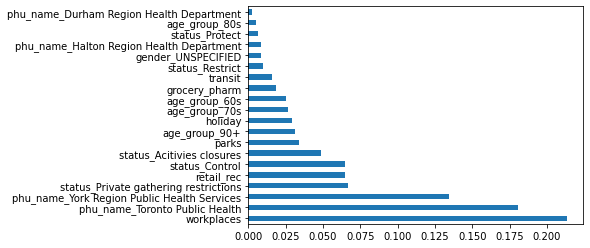

In [36]:
importance = pd.Series(classifier.feature_importances_, index=new_result.columns)
importance.nlargest(20).plot(kind='barh')


In [37]:
#Random Forest
X_train, X_test, y_train, y_test = train_test_split(x_under, y_under, test_size=0.33, shuffle=True, stratify=y_under)

#create and fit random forest
a = datetime.datetime.now()#start time
rf = RandomForestClassifier(max_depth=2, random_state=0)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
b = datetime.datetime.now()#end time
c = b - a

print('time in milliseconds')
print(c.total_seconds() * 1000)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Classification Report")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_pred, y_test) * 100
recall = recall_score(y_pred, y_test) * 100
precision = precision_score(y_pred, y_test) * 100

print("Accuracy of Random Forest: {:.2f} %".format(accuracy))
print("Precision of Random Forest: {:.2f} %".format(precision))
print("Recall of Random Forest: {:.2f} %".format(recall))


time in milliseconds
359.184
Confusion Matrix:
[[371 100]
 [177 293]]
Classification Report
              precision    recall  f1-score   support

       False       0.68      0.79      0.73       471
        True       0.75      0.62      0.68       470

    accuracy                           0.71       941
   macro avg       0.71      0.71      0.70       941
weighted avg       0.71      0.71      0.70       941

Accuracy of Random Forest: 70.56 %
Precision of Random Forest: 62.34 %
Recall of Random Forest: 74.55 %


<AxesSubplot:>

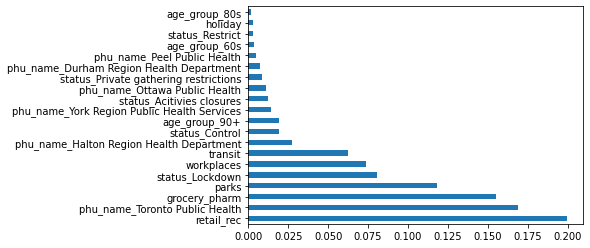

In [38]:
importance = pd.Series(rf.feature_importances_, index=new_result.columns)
importance.nlargest(20).plot(kind='barh')


In [39]:
#Decision Tree Algorithm:
X_train, X_test, y_train, y_test = train_test_split(x_under, y_under, test_size=0.33, shuffle=True, stratify=y_under)
from sklearn import tree
from matplotlib import pyplot as plt
import graphviz

a = datetime.datetime.now()
dt = DecisionTreeClassifier(criterion='entropy')
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
b = datetime.datetime.now()
c = b - a

print('time in milliseconds')
print(c.total_seconds() * 1000)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Classification Report")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_pred,y_test) * 100  
recall = recall_score(y_pred, y_test) * 100 
precision = precision_score(y_pred, y_test) * 100

print("Accuracy of Decision Tree: {:.2f} %".format(accuracy))
print("Recall of Decision Tree: {:.2f} %".format(recall))
print("Precision of Decision Tree: {:.2f} %".format(precision))



time in milliseconds
10.932
Confusion Matrix:
[[413  57]
 [167 304]]
Classification Report
              precision    recall  f1-score   support

       False       0.71      0.88      0.79       470
        True       0.84      0.65      0.73       471

    accuracy                           0.76       941
   macro avg       0.78      0.76      0.76       941
weighted avg       0.78      0.76      0.76       941

Accuracy of Decision Tree: 76.20 %
Recall of Decision Tree: 84.21 %
Precision of Decision Tree: 64.54 %


<AxesSubplot:>

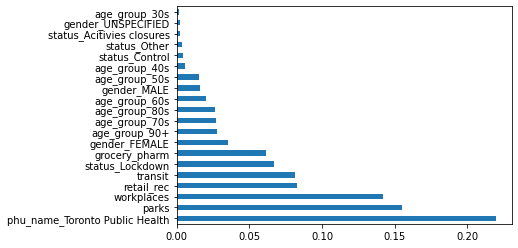

In [40]:
importance = pd.Series(dt.feature_importances_, index=new_result.columns)
importance.nlargest(20).plot(kind='barh')

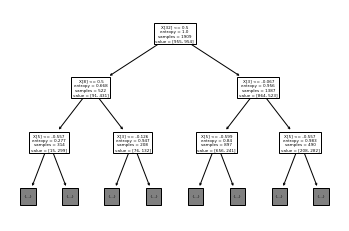

In [41]:
tree.plot_tree(dt,max_depth=2)
plt.show() 

In [42]:
dot_data = tree.export_graphviz(dt, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("DecisionTree") 

'DecisionTree.pdf'

In [43]:
#PART C
from sklearn.svm import OneClassSVM


train, test = train_test_split(new_result, test_size=.2) 
train_normal = train[train['y']==0] 
train_outliers = train[train['y']==1] 
outlier_prop = len(train_outliers) / len(train_normal) 
svm = OneClassSVM(kernel='rbf', nu=outlier_prop, gamma=0.000001) 
svm.fit(train_normal[['x1','x4','x5']])



KeyError: 'y'